#### Important Note

###### This code follows the modular approach instead of squential

###### So, task number is written on the top of each function performing specific task

#### Section A: Data Preprocessing

##### Import the Libraries

In [6]:
import csv
import json
from datetime import datetime

##### Define mappings for nested structures

###### Task 2 requirement

In [10]:
NESTED_MAPPINGS = {
    "Address": ["Address Street", "Address City", "Address Postcode"],
    "CreditCard": [
        "Credit Card Start Date", "Credit Card Expiry Date",
        "Credit Card Number", "Credit Card CVV", "Bank IBAN"
    ],
    "Vehicle": ["Vehicle Make", "Vehicle Model", "Vehicle Year", "Vehicle Type"]
}

##### Type casting functions with Error Handling

In [13]:
def safe_int(value):
    return int(value) if value.strip() else 0

def safe_bool(value):
    return value.lower() == "true" if value.strip() else False

def safe_float(value):
    return float(value) if value.strip() else 0

TYPE_CASTS = {
    "Age (Years)": safe_int,
    "Dependants": safe_int,
    "Yearly Salary (Dollar)": safe_float,
    "Yearly Pension (Dollar)": safe_float,
    "Distance Commuted to Work (Km)": safe_float,
    "Vehicle Year": safe_int,
    "Retired": safe_bool,
    "Credit Card Number": safe_int,
    "Credit Card CVV": safe_int,
}

#### Task 2 & 3: Function to transfer CSV File into JSON File Format and Handling the Dependants issue

In [16]:
def transform_row(row, faulty_rows, current_row):
    """Convert a flat row into a structured dictionary with type conversions."""
    transformed = {}

    for key, value in row.items():
        value = value.strip()

        if key in TYPE_CASTS:
            if key == "Dependants" and value in ["", " "]:
                faulty_rows.append(current_row)
            value = TYPE_CASTS[key](value)
            
        for category, fields in NESTED_MAPPINGS.items():
            if key in fields:
                field_name = key.split()[-1] if "Credit Card" not in key else key.split()[-2] + key.split()[-1]
                transformed.setdefault(category, {})[field_name] = value
                break
        else:
            transformed[key.replace(" ", "")] = value

    # Format the Credit Card number if it exists
    if "CreditCard" in transformed and "CardNumber" in transformed["CreditCard"]:
        try:
            card_number_int = int(transformed["CreditCard"]["CardNumber"])  # Convert to int
            card_number_str = str(card_number_int)  # Convert back to string
            formatted_card_number = '-'.join([card_number_str[i:i+4] for i in range(0, len(card_number_str), 4)])
            transformed["CreditCard"]["CardNumber"] = formatted_card_number
        except ValueError:
            pass  # Handle cases where conversion fails

    return transformed


##### Task 1: Function to Load CSV File and Count rows with faulty dependents value

In [19]:
def parse_csv(file_path):
 
    faulty_rows = []
    data = []

    with open(file_path, mode="r", encoding="utf-8") as file:
        reader = csv.DictReader(file)
        for current_row, row in enumerate(reader, start=1):
            data.append(transform_row(row, faulty_rows, current_row))

    return data, faulty_rows

##### Task 4: Function to write JSON data to a file

In [22]:
def write_json(filename, data):

    with open(f"{filename}.json", "w", encoding="utf-8") as file:
        json.dump(data, file, indent=4)
        print(f"✅ Data saved to {filename}.json successfully!")

##### Task 6: Function to find customers with invalid credit card

In [25]:
def should_flag_credit_card(person):

    try:
        credit_card_info = person.get("CreditCard", {})
        start_date_str = credit_card_info.get("StartDate", "")
        end_date_str = credit_card_info.get("ExpiryDate", "")

        if not start_date_str or not end_date_str:
            return False

        start_date = datetime.strptime(start_date_str, "%m/%y")
        end_date = datetime.strptime(end_date_str, "%m/%y")

        year_difference = (end_date.year - start_date.year) + ((end_date.month - start_date.month) / 12)

        return year_difference > 10

    except ValueError:
        return False

##### Task 7: Additional metric Calculation (Salary Commute)

In [28]:
def calculate_salary_commute(person):
    salary = person.get("YearlySalary(Dollar)", 0)
    commute_km = person.get("DistanceCommutedtoWork(Km)", 1)
    
    return salary if commute_km <= 1 else round(salary / commute_km, 2)

##### Function to handle all the inner implementation

In [31]:
def process_data(file_path):
    """Main function to parse, process, and store customer data."""

    '''Task 1, 2 and 3: Implementation for reading csv, handling Dependant error and Type casting '''
    
    nested_data, faulty_rows = parse_csv(file_path)
    print("⚠️ Problematic Dependant Rows: ", faulty_rows)

    '''Task 4: Writing processed.json'''
    
    write_json("processed", nested_data)

    '''Task 5: Implementation for retired.json and employeed.json''' 
    
    retired_users = [p for p in nested_data if p.get("Retired")]
    employed_users = [p for p in nested_data if not p.get("Retired")]

    write_json("retired", retired_users)
    write_json("employed", employed_users)

    '''Task 6: Implementation for remove_ccard.json '''
    
    flagged_customers = [p for p in nested_data if should_flag_credit_card(p)]
    write_json("remove_ccard", flagged_customers)

    '''Task 7: As, mention in assignment to load data from processed json and then compute the Salary Commute '''
    
    with open("processed.json", "r", encoding="utf-8") as file:
        nested_data = json.load(file)

    for person in nested_data:
        person["Salary-Commute"] = calculate_salary_commute(person)

    nested_data.sort(key=lambda x: x["Salary-Commute"])
    write_json("commute", nested_data)


#### Main Task

In [34]:
if __name__ == "__main__":
    process_data("acw_user_data.csv")

⚠️ Problematic Dependant Rows:  [22, 110, 180, 206, 271, 273, 275, 359, 461, 469, 580, 637, 680, 726, 823, 866, 918, 932, 984]
✅ Data saved to processed.json successfully!
✅ Data saved to retired.json successfully!
✅ Data saved to employed.json successfully!
✅ Data saved to remove_ccard.json successfully!
✅ Data saved to commute.json successfully!


#### Section B: Data Visualisation

##### Import Libraries

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

##### Loading Data

In [40]:
file_path = "acw_user_data.csv"  
df = pd.read_csv(file_path)

##### Convert relevant columns to numeric, handling errors

In [42]:
df["Yearly Salary (Dollar)"] = pd.to_numeric(df["Yearly Salary (Dollar)"], errors="coerce")
df["Distance Commuted to Work (Km)"] = pd.to_numeric(df["Distance Commuted to Work (Km)"], errors="coerce")
df["Age (Years)"] = pd.to_numeric(df["Age (Years)"], errors="coerce")
df["Dependants"] = pd.to_numeric(df["Dependants"], errors="coerce").fillna(0).astype(int)

#####  Calculating Median and Mean

In [47]:
mean_salary = df["Yearly Salary (Dollar)"].mean()
median_age = df["Age (Years)"].median()

print(f"Mean Salary: ${mean_salary:,.2f}")
print(f"Median Age: {median_age} years")

Mean Salary: $57,814.08
Median Age: 54.0 years


##### Setting Seaborn Style

In [50]:
sns.set_style("whitegrid")

##### Save directory setup

In [53]:
plot_dir = "plots"
os.makedirs(plot_dir, exist_ok=True)

#### Task 1: Mean Median Plots

##### --- Plot A: Histogram of Salary Distribution ---

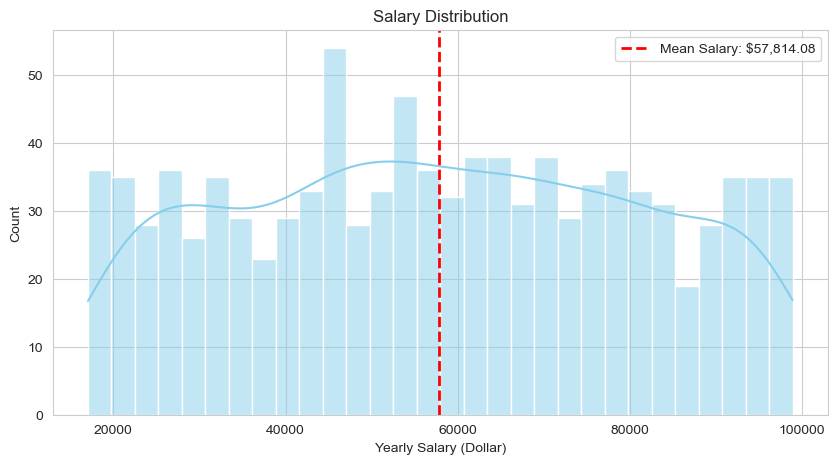

In [57]:

plt.figure(figsize=(10, 5))
sns.histplot(df["Yearly Salary (Dollar)"], bins=30, kde=True, color="skyblue")
plt.axvline(mean_salary, color='red', linestyle='dashed', linewidth=2, label=f"Mean Salary: ${mean_salary:,.2f}")
plt.title("Salary Distribution")
plt.xlabel("Yearly Salary (Dollar)")
plt.ylabel("Count")
plt.legend()
plt.savefig(f"{plot_dir}/salary_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

##### --- Plot B: Boxplot of Age Distribution ---

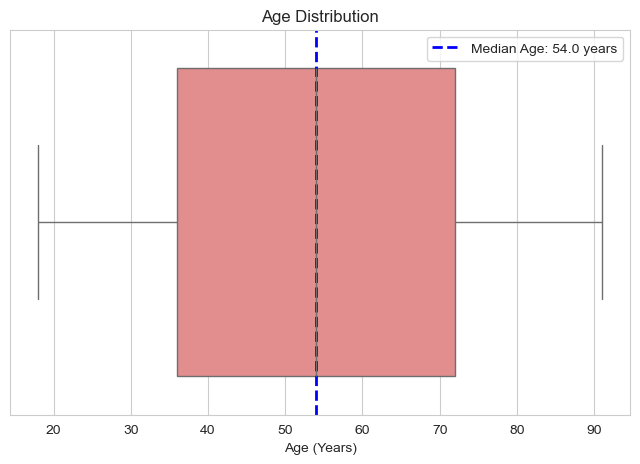

In [60]:

plt.figure(figsize=(8, 5))
sns.boxplot(x=df["Age (Years)"], color="lightcoral")
plt.axvline(median_age, color='blue', linestyle='dashed', linewidth=2, label=f"Median Age: {median_age} years")
plt.title("Age Distribution")
plt.xlabel("Age (Years)")
plt.legend()
plt.savefig(f"{plot_dir}/age_boxplot.png", dpi=300, bbox_inches="tight")
plt.show()

#### Task 2: Univariate Plots

##### --- Plot A: Age Histogram (Bin width = 5) ---

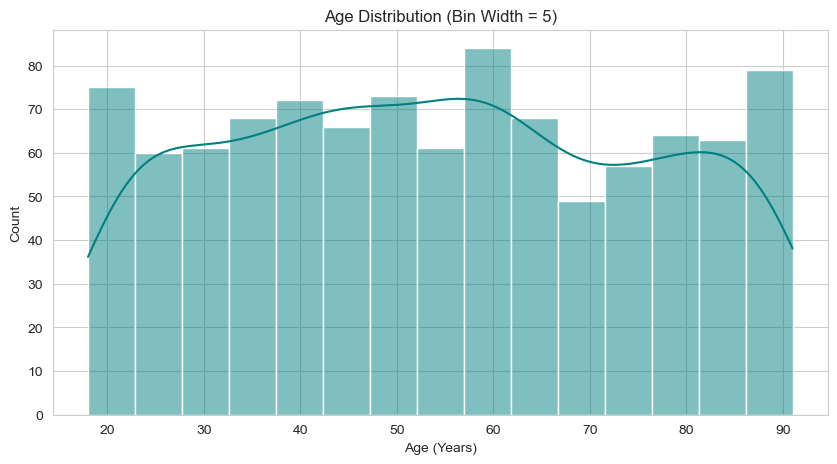

In [64]:

bin_width = 5
num_bins = int(np.ceil((df["Age (Years)"].max() - df["Age (Years)"].min()) / bin_width))

plt.figure(figsize=(10, 5))
sns.histplot(df["Age (Years)"], bins=num_bins, kde=True, color="teal")
plt.title("Age Distribution (Bin Width = 5)")
plt.xlabel("Age (Years)")
plt.ylabel("Count")
plt.savefig(f"{plot_dir}/age_histogram.png", dpi=300, bbox_inches="tight")
plt.show()

##### --- Plot B: Dependents Count Plot ---

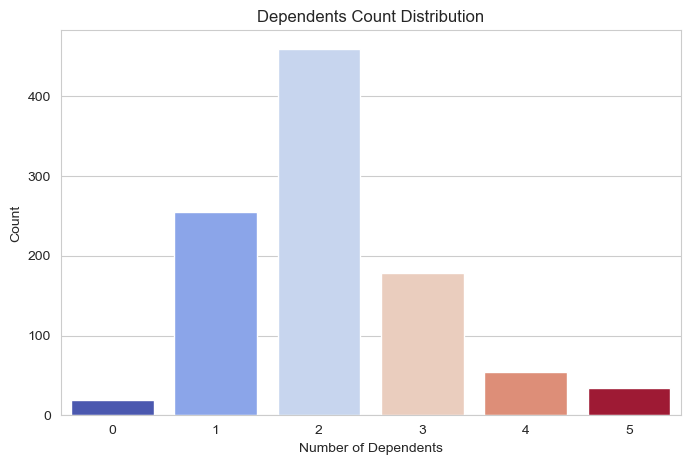

In [67]:

plt.figure(figsize=(8, 5))
sns.countplot(x=df["Dependants"], hue=df["Dependants"], palette="coolwarm", legend=False)
plt.title("Dependents Count Distribution")
plt.xlabel("Number of Dependents")
plt.ylabel("Count")
plt.savefig(f"{plot_dir}/dependents_count.png", dpi=300, bbox_inches="tight")
plt.show()

##### --- Plot C: Age Distribution Conditioned on Marital Status ---

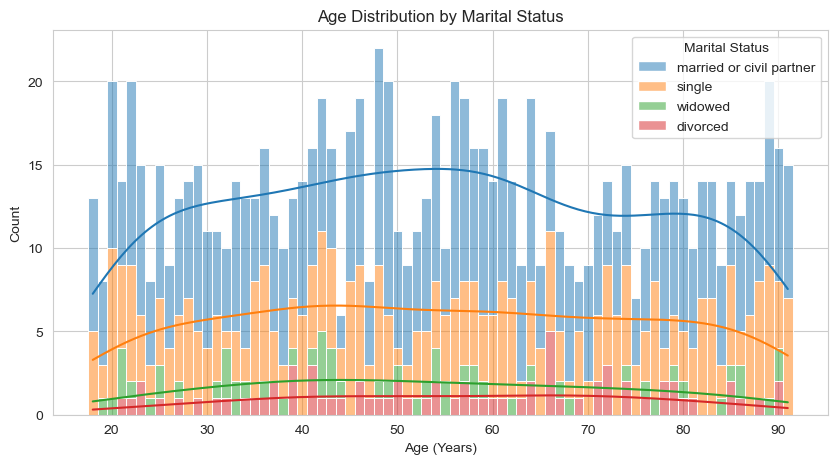

In [70]:

plt.figure(figsize=(10, 5))
ax = sns.histplot(df, x="Age (Years)", hue="Marital Status", multiple="stack", kde=True, discrete=True)
plt.title("Age Distribution by Marital Status")
plt.xlabel("Age (Years)")
plt.ylabel("Count")

# Manually create the legend
handles, labels = ax.get_legend_handles_labels()
if labels:  # Only add a legend if labels exist
    plt.legend(handles, labels, title="Marital Status")
plt.show()

#### Task 3: Multivariate Plots

##### --- Plot A: Distance Commuted vs Salary ---

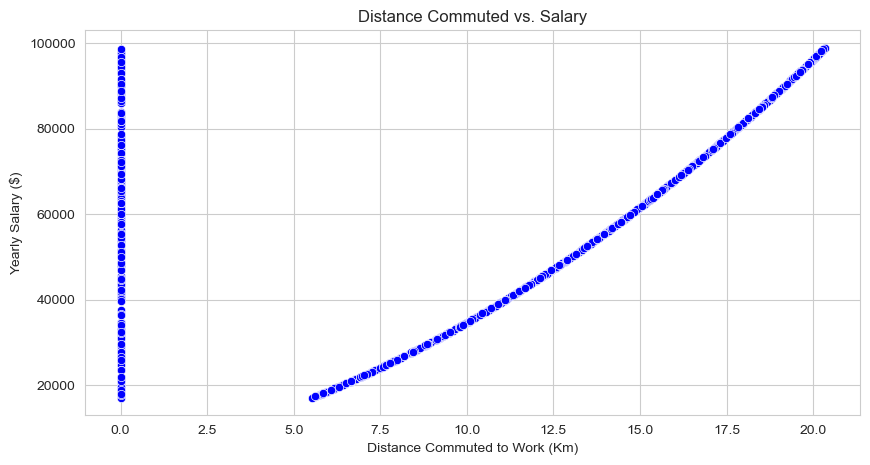

In [74]:

plt.figure(figsize=(10, 5))
sns.scatterplot(x=df["Distance Commuted to Work (Km)"], y=df["Yearly Salary (Dollar)"], color="blue")
plt.title("Distance Commuted vs. Salary")
plt.xlabel("Distance Commuted to Work (Km)")
plt.ylabel("Yearly Salary ($)")
plt.savefig(f"{plot_dir}/distance_vs_salary.png", dpi=300, bbox_inches="tight")
plt.show()

##### --- Plot B: Age vs Salary with Regression Line ---

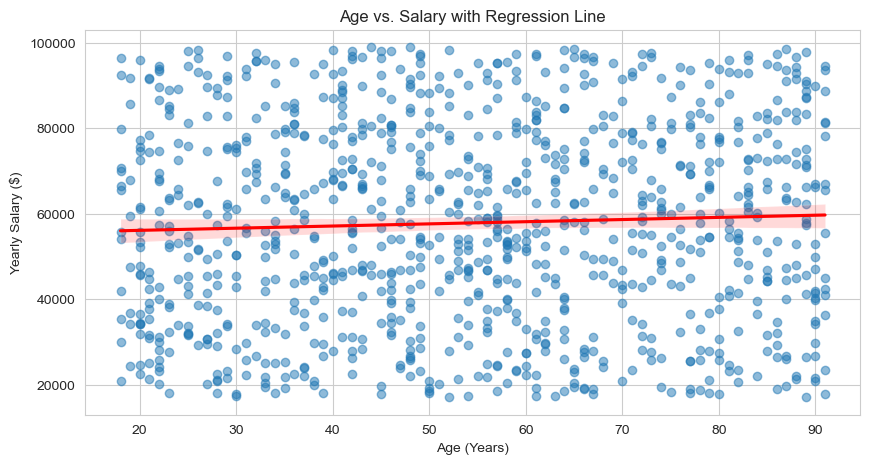

In [77]:

plt.figure(figsize=(10, 5))
sns.regplot(x=df["Age (Years)"], y=df["Yearly Salary (Dollar)"], scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.title("Age vs. Salary with Regression Line")
plt.xlabel("Age (Years)")
plt.ylabel("Yearly Salary ($)")
plt.savefig(f"{plot_dir}/age_vs_salary.png", dpi=300, bbox_inches="tight")
plt.show()

##### --- Plot C: Age vs Salary Conditioned by Dependants ---

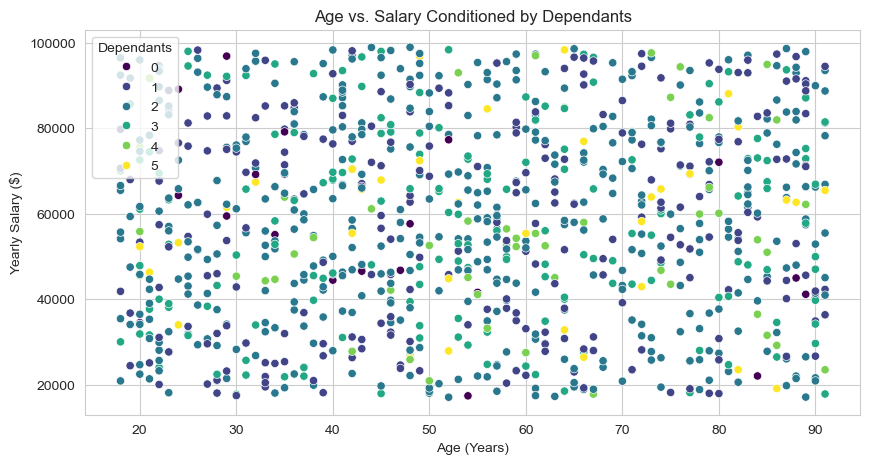

In [80]:

plt.figure(figsize=(10, 5))
sns.scatterplot(x=df["Age (Years)"], y=df["Yearly Salary (Dollar)"], hue=df["Dependants"], palette="viridis")
plt.title("Age vs. Salary Conditioned by Dependants")
plt.xlabel("Age (Years)")
plt.ylabel("Yearly Salary ($)")
plt.legend(title="Dependants")
plt.savefig(f"{plot_dir}/age_vs_salary_dependants.png", dpi=300, bbox_inches="tight")
plt.show()




#### Task 4: Saving the plots

In [87]:
print(f"✅ All plots have been saved in the '{plot_dir}' directory.")

✅ All plots have been saved in the 'plots' directory.
